In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols 
import sklearn as sk
from sklearn.model_selection import train_test_split
import yfinance as yf

def fetch_data(ticker, start="1995-01-01", end="2025-01-01"):
    df = yf.download(ticker, start=start, end=end, auto_adjust=True)


    if isinstance(df.index, pd.MultiIndex):
        df.index = df.index.get_level_values(-1)

    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    return df


car_sales = pd.read_csv(
    r"daily_car_sales.csv",
    parse_dates=["Date"]
)

car_sales.columns = car_sales.columns.str.strip()

numeric_cols = car_sales.select_dtypes(include='number').columns.tolist()
if 'Date' in numeric_cols:
    numeric_cols.remove('Date')

if not numeric_cols:
    raise ValueError("No numeric sales column found. Please check your CSV.")

sales_col = numeric_cols[0]  

print(f"Detected sales column: {sales_col}")


crude_oil = fetch_data("CL=F")
imo_stock = fetch_data("IMO")
usd_cad   = fetch_data("CAD=X")

# Force all Date columns to datetime
for df in [car_sales, crude_oil, imo_stock, usd_cad]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge datasets
merge_targets = [
    (crude_oil, 'Crude_Oil_Close'),
    (imo_stock, 'IMO_Close'),
    (usd_cad,   'USD_CAD_Close')
]

merged_df = car_sales.copy()
for df, col_name in merge_targets:
    right_df = df[['Date', 'Close']].copy()
    right_df.columns = ['Date', col_name]
    merged_df = pd.merge(merged_df, right_df, on='Date', how='left')

# Fill forward for non-trading days
merged_df = merged_df.sort_values('Date')
merged_df[['Crude_Oil_Close', 'IMO_Close', 'USD_CAD_Close']] = (
    merged_df[['Crude_Oil_Close', 'IMO_Close', 'USD_CAD_Close']].ffill()
)

print(merged_df.head())


Detected sales column: Daily_electric


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

        Date  Daily_electric  Daily_nonelectric  Daily_total  Crude_Oil_Close  \
0 1995-01-01               2                227          229              NaN   
1 1995-01-02               3                779          782              NaN   
2 1995-01-03               0               2733         2733              NaN   
3 1995-01-04               2                 10           12              NaN   
4 1995-01-05               0               2975         2975              NaN   

   IMO_Close  USD_CAD_Close  
0        NaN            NaN  
1        NaN            NaN  
2   1.820837            NaN  
3   1.827760            NaN  
4   1.827760            NaN  


In [3]:
# Drop any rows with nulls in the key columns
clean_df = merged_df.dropna(
    subset=['IMO_Close', 'Crude_Oil_Close', 'USD_CAD_Close', sales_col]
).copy()

print(f"Original rows: {len(merged_df)}, After cleaning: {len(clean_df)}")
print(clean_df.head())

Original rows: 11183, After cleaning: 8002
           Date  Daily_electric  Daily_nonelectric  Daily_total  \
3181 2003-09-17               0               9162         9162   
3182 2003-09-18               1                448          449   
3183 2003-09-19               1               1274         1275   
3184 2003-09-20               1               2533         2534   
3185 2003-09-21               3               2102         2105   

      Crude_Oil_Close  IMO_Close  USD_CAD_Close  
3181        27.030001   8.774080         1.3667  
3182        27.170000   8.626988         1.3615  
3183        27.030001   8.608315         1.3472  
3184        27.030001   8.608315         1.3472  
3185        27.030001   8.608315         1.3472  


### Correlation Analysis


Correlation Matrix:
                    IMO_Close  Crude_Oil_Close  USD_CAD_Close  Daily_electric  \
IMO_Close           1.000000         0.559987       0.061486        0.483854   
Crude_Oil_Close     0.559987         1.000000      -0.620497        0.046476   
USD_CAD_Close       0.061486        -0.620497       1.000000        0.381905   
Daily_electric      0.483854         0.046476       0.381905        1.000000   
Daily_nonelectric   0.010076        -0.017114       0.026787        0.021152   

                   Daily_nonelectric  
IMO_Close                   0.010076  
Crude_Oil_Close            -0.017114  
USD_CAD_Close               0.026787  
Daily_electric              0.021152  
Daily_nonelectric           1.000000  


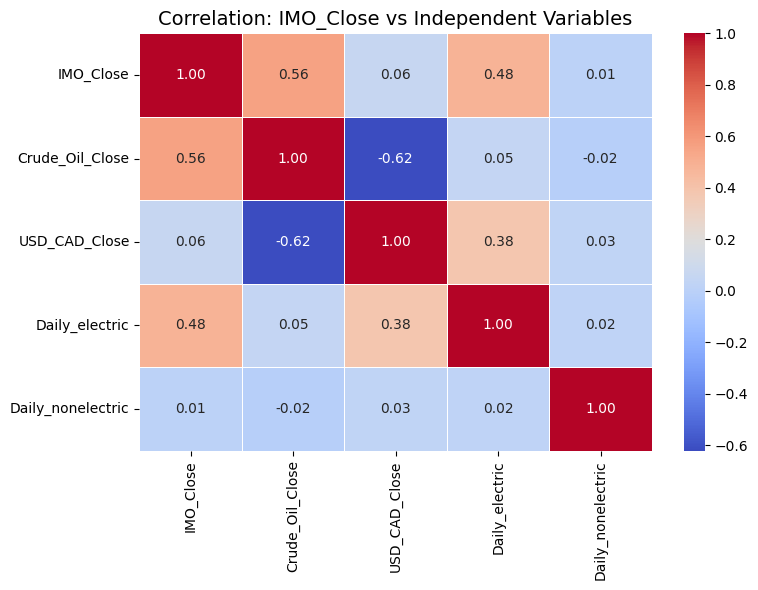

In [4]:
#Define the key columns
key_columns = [
    'IMO_Close',
    'Crude_Oil_Close',
    'USD_CAD_Close',
    'Daily_electric',
    'Daily_nonelectric'
]

clean_df = merged_df.dropna(subset=key_columns).copy()

# Compute correlation matrix
corr_matrix = clean_df[key_columns].corr()

print("\nCorrelation Matrix:\n", corr_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation: IMO_Close vs Independent Variables", fontsize=14)
plt.tight_layout()
plt.show()

### Train-Test Split

In [5]:

#Features (X) and target (y)
X = clean_df[['Crude_Oil_Close', 'USD_CAD_Close', 'Daily_electric', 'Daily_nonelectric']]
y = clean_df['IMO_Close']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% test set
    random_state=42     # reproducible split
)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")

Training set size: 6401 rows
Test set size: 1601 rows


### Training & Evaluating Linear Regression Model

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#Initialize and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(X.columns, model.coef_)))
print(f"R-squared on test set: {r2:.4f}")
print(f"RMSE on test set: {rmse:.4f}")

Intercept: -63.52593889200139
Coefficients: {'Crude_Oil_Close': np.float64(0.5153990201476827), 'USD_CAD_Close': np.float64(47.74814391758329), 'Daily_electric': np.float64(0.009374988409472707), 'Daily_nonelectric': np.float64(1.7735485968728426e-06)}
R-squared on test set: 0.6286
RMSE on test set: 8.0504


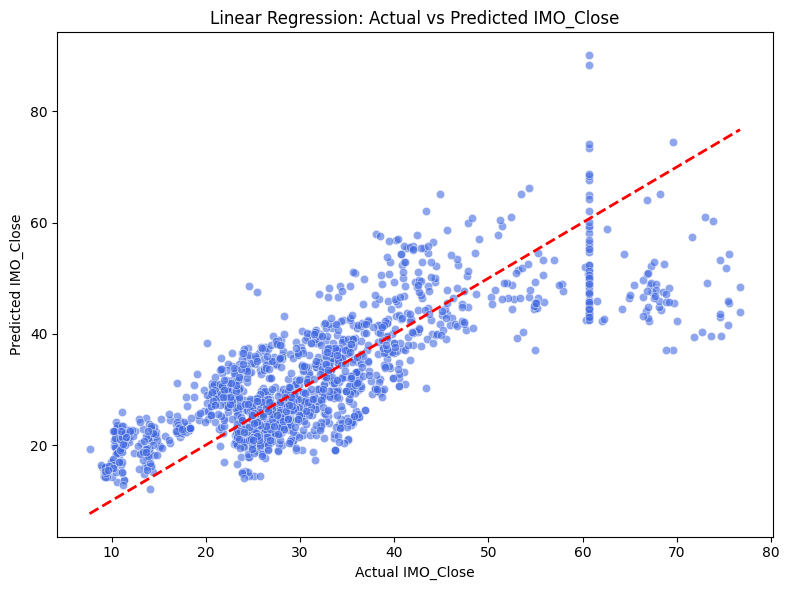

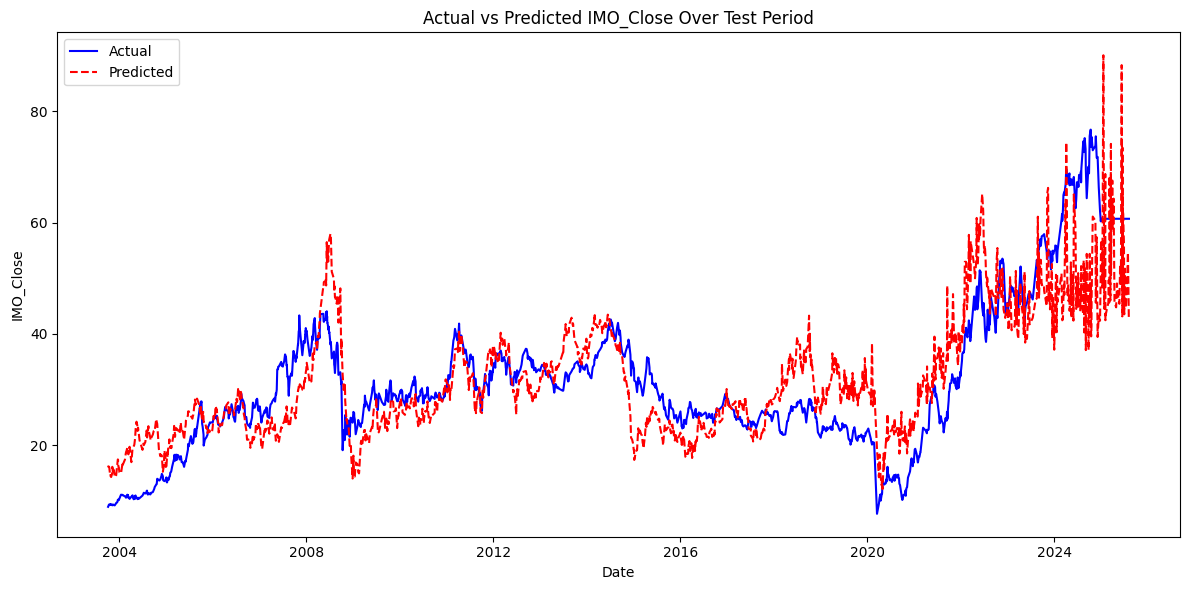

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

#Scatter plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual IMO_Close")
plt.ylabel("Predicted IMO_Close")
plt.title("Linear Regression: Actual vs Predicted IMO_Close")
plt.tight_layout()
plt.show()

# Time series overlay (chronological)
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
if 'Date' in clean_df.columns:
    results_df['Date'] = clean_df.loc[y_test.index, 'Date']
    results_df = results_df.sort_values('Date')

    plt.figure(figsize=(12,6))
    plt.plot(results_df['Date'], results_df['Actual'], label='Actual', color='blue')
    plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', color='red', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("IMO_Close")
    plt.title("Actual vs Predicted IMO_Close Over Test Period")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Fit linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

#Predictions
y_pred = model.predict(X_test_scaled)

#Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(X.columns, model.coef_)))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

Intercept: 31.487433400829776
Coefficients: {'Crude_Oil_Close': np.float64(11.307649155647463), 'USD_CAD_Close': np.float64(6.587571036803554), 'Daily_electric': np.float64(3.310968113072335), 'Daily_nonelectric': np.float64(0.006630455744504077)}
Root Mean Squared Error (RMSE): 8.0504
R-squared Score: 0.6286


### Cyclical Feature Encoding

In [9]:
# Creating cyclical features
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek

merged_df['Month_sin'] = np.sin(2 * np.pi * merged_df['Month'] / 12)
merged_df['Month_cos'] = np.cos(2 * np.pi * merged_df['Month'] / 12)
merged_df['DOW_sin']   = np.sin(2 * np.pi * merged_df['DayOfWeek'] / 7)
merged_df['DOW_cos']   = np.cos(2 * np.pi * merged_df['DayOfWeek'] / 7)

# Dropping rows with missing values in all features + target
features = [
    'Crude_Oil_Close', 'USD_CAD_Close',
    'Daily_electric', 'Daily_nonelectric',
    'Month_sin', 'Month_cos', 'DOW_sin', 'DOW_cos'
]
target = 'IMO_Close'

clean_df = merged_df.dropna(subset=features + [target]).copy()

# Train-test split
X = clean_df[features]
y = clean_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions & evaluation
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(features, model.coef_)))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

Intercept: 31.487433400829776
Coefficients: {'Crude_Oil_Close': np.float64(11.437948728095144), 'USD_CAD_Close': np.float64(6.652746418650815), 'Daily_electric': np.float64(3.326364533777336), 'Daily_nonelectric': np.float64(0.05732392093556374), 'Month_sin': np.float64(-0.07962035051415794), 'Month_cos': np.float64(0.7362928949695929), 'DOW_sin': np.float64(-0.11994026161757791), 'DOW_cos': np.float64(0.08339137827598972)}
Root Mean Squared Error (RMSE): 8.0529
R-squared Score: 0.6284


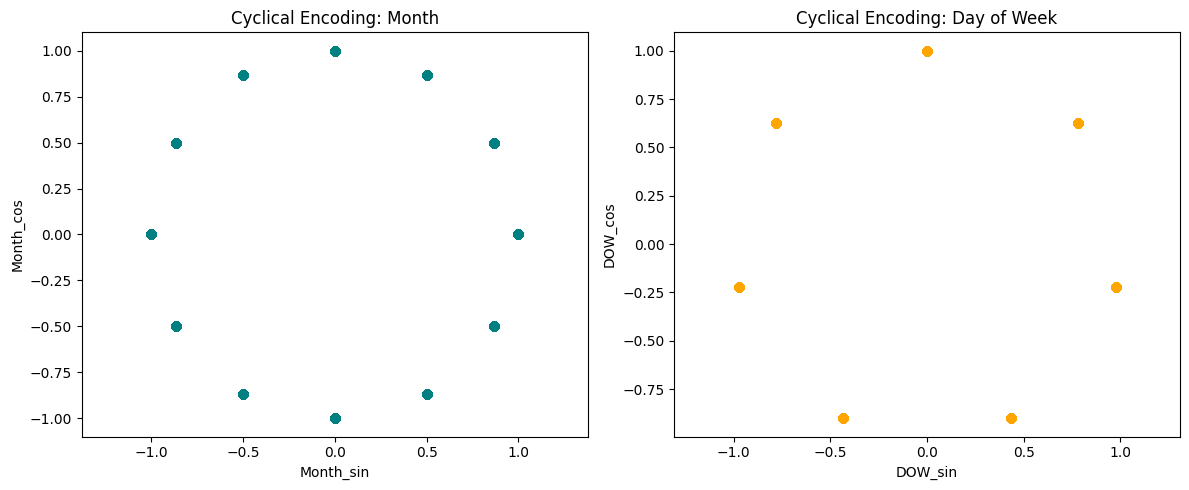

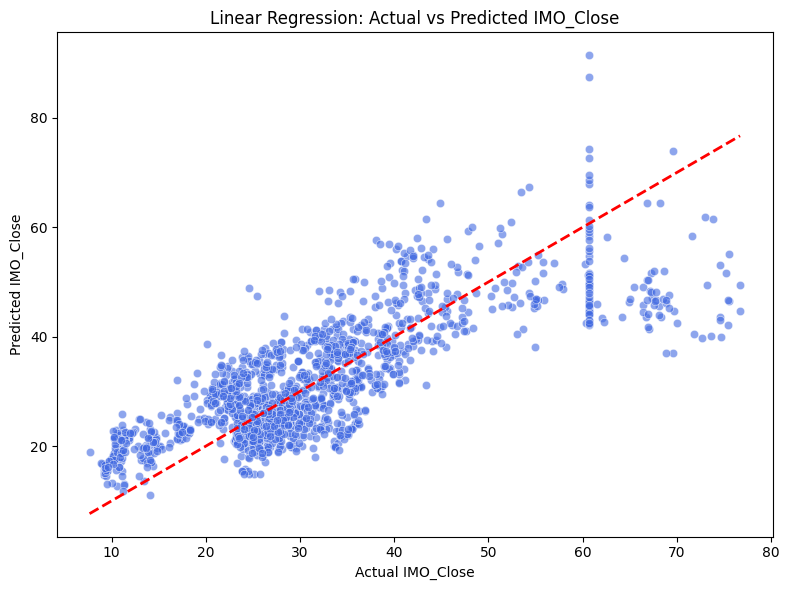

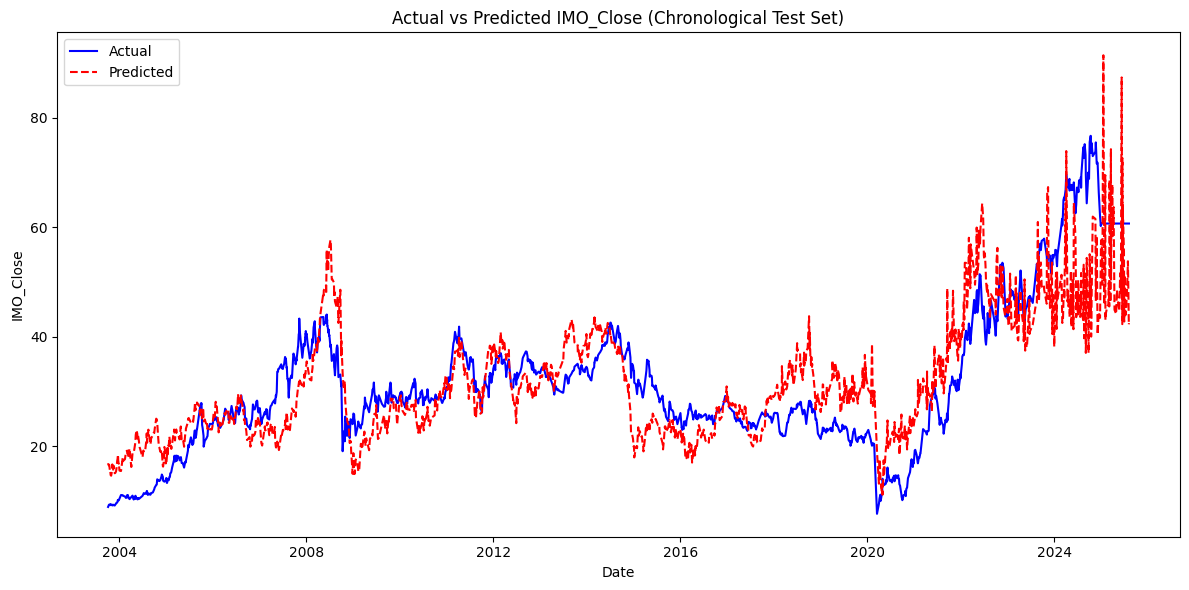

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize cyclical features
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Month encoding
axes[0].scatter(clean_df['Month_sin'], clean_df['Month_cos'], alpha=0.6, color='teal')
axes[0].set_title('Cyclical Encoding: Month')
axes[0].set_xlabel('Month_sin')
axes[0].set_ylabel('Month_cos')
axes[0].axis('equal')

# Day of Week encoding
axes[1].scatter(clean_df['DOW_sin'], clean_df['DOW_cos'], alpha=0.6, color='orange')
axes[1].set_title('Cyclical Encoding: Day of Week')
axes[1].set_xlabel('DOW_sin')
axes[1].set_ylabel('DOW_cos')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual IMO_Close")
plt.ylabel("Predicted IMO_Close")
plt.title("Linear Regression: Actual vs Predicted IMO_Close")
plt.tight_layout()
plt.show()

# Rebuilding a DataFrame with Date, actual, and predicted
results_df = clean_df.loc[y_test.index, ['Date', target]].copy()
results_df['Predicted'] = y_pred

# Sorting by Date for time‑series plotting
results_df = results_df.sort_values('Date')

plt.figure(figsize=(12,6))
plt.plot(results_df['Date'], results_df[target], label='Actual', color='blue')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("IMO_Close")
plt.title("Actual vs Predicted IMO_Close (Chronological Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

### Trying Random Forest Regressor

In [11]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Fit Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=200,       # number of trees
    max_depth=None,         # trees expansion - full
    random_state=42,
    n_jobs=-1               # using all CPU cores
)
rf_model.fit(X_train, y_train)

# Predictions & evaluation
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: {rmse:.4f}")
print(f"Random Forest R²: {r2:.4f}")

# Feature importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:\n", importances)

Random Forest RMSE: 2.2609
Random Forest R²: 0.9707

Feature Importances:
 Crude_Oil_Close      0.533212
USD_CAD_Close        0.398846
Month_cos            0.022147
Daily_electric       0.019263
Month_sin            0.018209
Daily_nonelectric    0.005514
DOW_sin              0.001772
DOW_cos              0.001038
dtype: float64


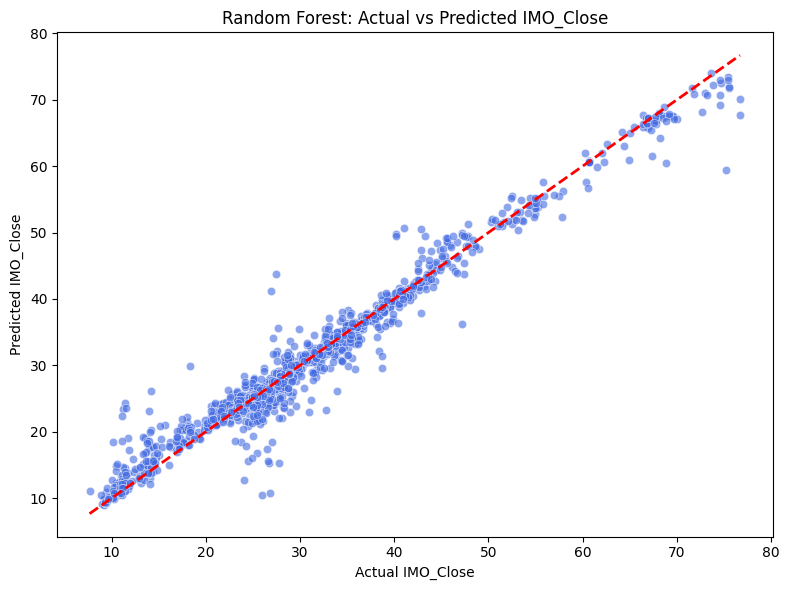

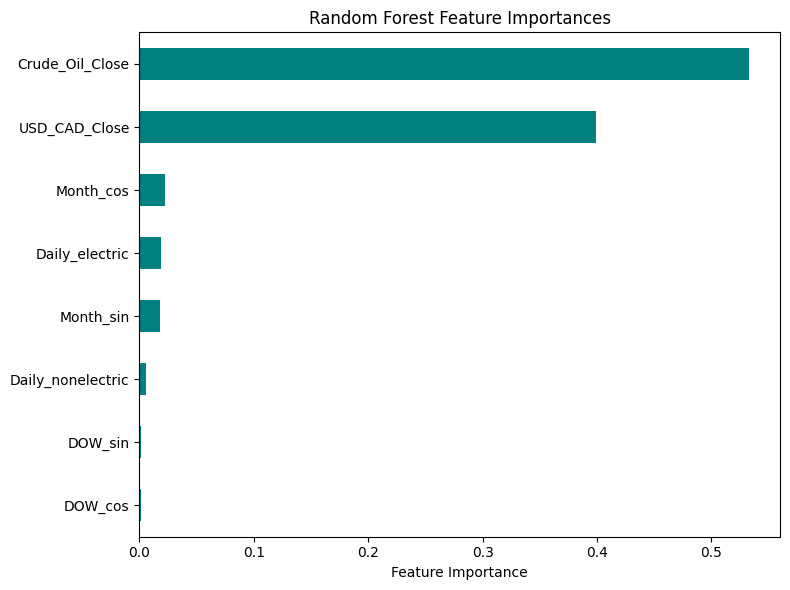

In [12]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual IMO_Close")
plt.ylabel("Predicted IMO_Close")
plt.title("Random Forest: Actual vs Predicted IMO_Close")
plt.tight_layout()
plt.show()

# Optional: Feature importance bar chart
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8,6))
importances.plot(kind='barh', color='teal')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

### Testing Hypotheses
**Hypothesis A (Oil Price Dependence):** Fluctuations in global crude oil prices have the greatest impact on the stock price movements of Imperial Oil Limited (IMO), compared to energy transition variables and macroeconomic indicators.

**Hypothesis B (Energy Transition Dependence):** Energy transition variables, such as electric vehicle (EV) sales and alternative fuel adoption, have the greatest impact on the stock price movements of Imperial Oil Limited (IMO), compared to crude oil prices and macroeconomic indicators.

**Hypothesis C (Macroeconomic Dependence):** Macroeconomic indicators, such as exchange rates, interest rates, and GDP growth, have the greatest impact on the stock price movements of Imperial Oil Limited (IMO), compared to crude oil prices and energy transition variables

**Hypothesis Null H₀:** No single factor group (crude oil prices, energy transition variables, or macroeconomic indicators) has a statistically greater impact on IMO’s stock price movements than the others; differences in their predictive contributions are not statistically significant.


In [13]:
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

# Grouping
oil_vars = ['Crude_Oil_Close']
energy_vars = ['Daily_electric', 'Daily_nonelectric']
macro_vars = ['USD_CAD_Close']

# Cyclical controls from Date
df = merged_df.copy()
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['DOW_sin']   = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DOW_cos']   = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
controls = ['Month_sin', 'Month_cos', 'DOW_sin', 'DOW_cos']

# Full predictor set & clean data
all_predictors = oil_vars + energy_vars + macro_vars + controls
target = 'IMO_Close'
df_clean = df.dropna(subset=[target] + all_predictors)

def fit_ols(y_col, x_cols):
    X = sm.add_constant(df_clean[x_cols])
    y = df_clean[y_col]
    return sm.OLS(y, X).fit()

# Full model
full_model = fit_ols(target, all_predictors)

# Reduced models (drop one group at a time, keep controls)
minus_oil    = fit_ols(target, energy_vars + macro_vars + controls)
minus_energy = fit_ols(target, oil_vars + macro_vars + controls)
minus_macro  = fit_ols(target, oil_vars + energy_vars + controls)

# Function to run nested-model ANOVA
def nested_test(reduced, full):
    a = anova_lm(reduced, full)
    return a['F'].iloc[1], a['Pr(>F)'].iloc[1], full.rsquared - reduced.rsquared

alpha = 0.05
tests = []
for name, reduced in [
    ('Oil', minus_oil),
    ('Energy', minus_energy),
    ('Macro', minus_macro)
]:
    f, p, dr2 = nested_test(reduced, full_model)
    tests.append({
        'Group': name,
        'ΔR²': dr2,
        'F-stat': f,
        'p-value': p,
        'Significant?': 'Yes' if p < alpha else 'No'
    })

results_df = pd.DataFrame(tests).sort_values(by='ΔR²', ascending=False)
print(results_df.to_string(index=False))

# Decision logic
best = results_df.iloc[0]
if best['Significant?'] == 'Yes':
    print(f"\n=> Supports Hypothesis { {'Oil':'A','Energy':'B','Macro':'C'}[best['Group']] }: "
          f"{best['Group']} group has the largest, statistically significant impact.")
else:
    print("\n=> Supports Null Hypothesis H₀: No group is significantly more impactful than the others.")

 Group      ΔR²      F-stat       p-value Significant?
   Oil 0.381690 8364.638539  0.000000e+00          Yes
 Macro 0.110571 2423.142190  0.000000e+00          Yes
Energy 0.047270  517.956718 3.037628e-212          Yes

=> Supports Hypothesis A: Oil group has the largest, statistically significant impact.


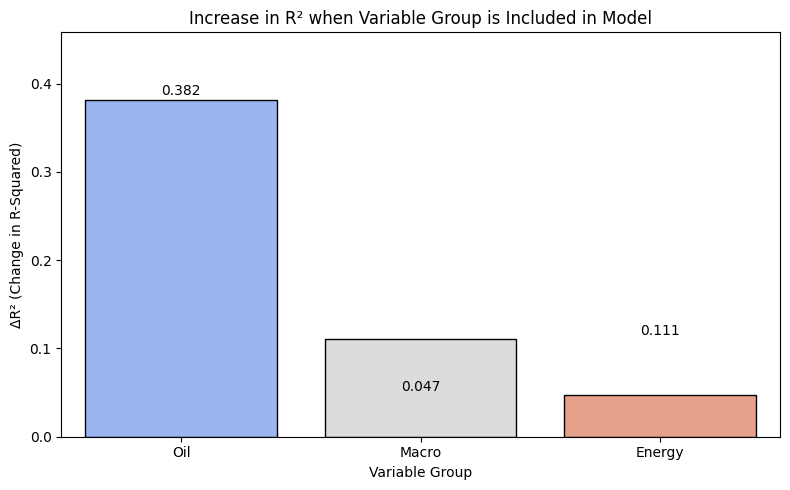

In [15]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df,
    x='Group',
    y='ΔR²',
    hue='Group',              # ← assign x to hue
    palette='coolwarm',
    edgecolor='black',
    legend=False              # ← hide legend
)
plt.title('Increase in R² when Variable Group is Included in Model')
plt.ylabel('ΔR² (Change in R-Squared)')
plt.xlabel('Variable Group')
plt.ylim(0, results_df['ΔR²'].max() * 1.2)

# Add labels above each bar
for index, row in results_df.iterrows():
    plt.text(index, row['ΔR²'] + 0.005, f"{row['ΔR²']:.3f}", ha='center')

plt.tight_layout()
plt.show()
